In [1]:
import numpy
import numpy as np
from modopt.math.metrics import mse, ssim
# import sys
# import time

# Package import
import pysap
from pysap.plugins.mri.reconstruct.linear import Wavelet2
from pysap.plugins.mri.reconstruct.fourier import FFT2, NFFT2
from pysap.plugins.mri.reconstruct_3D.fourier import NUFFT, FFT3
from pysap.plugins.mri.reconstruct.gradient import GradAnalysis2
from pysap.plugins.mri.reconstruct.gradient import GradSynthesis2
from pysap.plugins.mri.parallel_mri.reconstruct import sparse_rec_fista
from pysap.plugins.mri.reconstruct.utils import convert_mask_to_locations
from pysap.plugins.mri.parallel_mri.reconstruct import sparse_rec_condatvu
import pysap.extensions.transform
import warnings
from pysap.data import get_sample_data

/home/bs255482/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@gmail.com>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

nibabel        : >=2.1.0   - required | 2.2.1     installed
future         : >=0.16.0  - required | 0.16.0    installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
modopt         : >=1.1.4   - required | 1.1.5     installed
progressbar    : >=3.34.3  - required | 3.37.1    installed
numpy          : >=1.11.0  - required | 1.14.3    installed
scipy          : >=1.0.0   - required | 1.1.0     installed
pysparse       : >=0.0.1   - required | 0.0.1     installed
astropy        : ==2.0.4   - re

(512, 512)
[info] Image loaded for test: [(128, 128)].
(128, 128)
[info] Found 1 transformations.


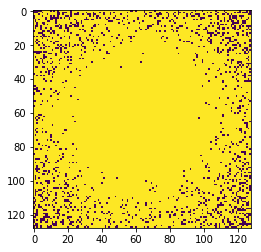

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [1. 1. 1. ... 1. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]
 [0. 1. 0. ... 1. 1. 1.]]


In [50]:
images_p_MRI = get_sample_data(dataset_name="2d-pmri")
mask_metadata = get_sample_data("mri-mask")
print(mask_metadata.shape)
mask = get_sample_data("mri-mask").data[256-64:256+64, 256-64:256+64]
images = pysap.Image(metadata=mask_metadata.metadata, shape=(128,128))
images.data = images_p_MRI.data[0,:,:]
images = [images]
print("[info] Image loaded for test: {0}.".format(
            [i.data.shape for i in images]))
print(mask.shape)
names = ['BsplineWaveletTransformATrousAlgorithm']
print("[info] Found {0} transformations.".format(len(names)))
nb_scales = [4]  # [2, 3, 4]
nb_iter = 300
images[0].show()

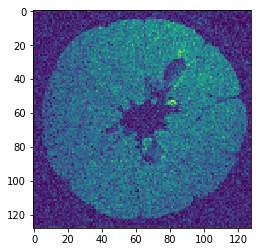

In [55]:
fourier = FFT2(samples=convert_mask_to_locations(
                                    numpy.fft.fftshift(mask)),
                   shape=image.shape)
k_sp = fourier.op(images[0])
I_0 = fourier.adj_op(k_sp)
plt.imshow(np.abs(I_0))

In [38]:
loc = convert_mask_to_locations(numpy.fft.fftshift(mask))
print(loc.max())
from pysap.plugins.mri.reconstruct.utils import convert_locations_to_mask
mask_r = convert_locations_to_mask(loc, mask.shape)
print(mask_r.shape)

0.4921875
(128, 128)


In [61]:
print('Process test NUFFT2 FISTA')
for image in images:
    fourier = FFT2(samples=convert_mask_to_locations(
                                    numpy.fft.fftshift(mask)),
                   shape=image.shape)
    non_z = numpy.nonzero(numpy.fft.fftshift(mask))
    data_fft = fourier.op(image.data)
    fourier_op_gen = NFFT2(samples=convert_mask_to_locations(
                                    mask),
                       shape=image.shape)
    data = fourier_op_gen.op(image.data)
    fourier_op = NFFT2(samples=convert_mask_to_locations(
                                    mask),
                       shape=image.shape)

    print("Process test with image '{0}'...".format(
        image.metadata["path"]))
    for nb_scale in nb_scales:
        print("- Number of scales: {0}".format(nb_scale))
        for name in names:
            print("    Transform: {0}".format(name))
            linear_op = Wavelet2(wavelet_name=name,
                                 nb_scale=nb_scale)
            gradient_op = GradAnalysis2(data=data,
                                         fourier_op=fourier_op)
            x_final, transform = sparse_rec_condatvu(
                                    gradient_op=gradient_op,
                                    linear_op=linear_op,
                                    std_est=0.0,
                                    std_est_method="dual",
                                    std_thr=0,
                                    mu=0,
                                    tau=None,
                                    sigma=None,
                                    relaxation_factor=1.0,
                                    nb_of_reweights=0,
                                    max_nb_of_iter=nb_iter,
                                    add_positivity=False,
                                    atol=1e-4,
                                    verbose=0)
            I_0 = fourier.adj_op(data_fft)
            print('MSE value: ', mse(x_final, I_0))
            print('SSIM Value: ', ssim(x_final, I_0,
                                       mask=None))
            print(numpy.max(numpy.abs(x_final-I_0)/numpy.abs(I_0)))
            mismatch = (1. - numpy.mean(
                numpy.isclose(x_final, I_0,
                              rtol=1e-3)))
            print("      mismatch = ", mismatch)

Process test NUFFT2 FISTA
Process test with image '/home/bs255482/.local/share/pysap/mask_BrainPhantom512.nii.gz'...
- Number of scales: 4
    Transform: BsplineWaveletTransformATrousAlgorithm


100% (300 of 300) |######################| Elapsed Time: 0:00:26 Time:  0:00:26


MSE value:  8.367486447036532e-31
test SSIM
SSIM Value:  0.9999999999999996
5.145627214165706e-13
      mismatch =  0.0


MSE value:  8.367486447036532e-31
test SSIM
SSIM Value:  0.9999999999999996
5.145627214165706e-13
      mismatch =  0.0


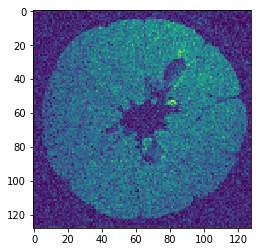

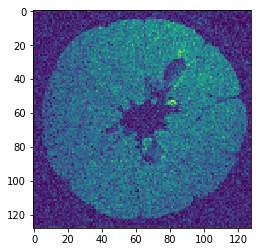

In [64]:
import matplotlib.pyplot as plt
I_0 = (fourier.adj_op(data_fft))
plt.imshow(numpy.abs(I_0))
plt.figure()
plt.imshow(np.abs(x_final))
print('MSE value: ', mse(x_final, I_0))
print('SSIM Value: ', ssim(x_final, I_0,
                                       mask=None))
print(numpy.max(numpy.abs(x_final-I_0)/numpy.abs(I_0)))
mismatch = (1. - numpy.mean(
                numpy.isclose(x_final, I_0,
                              rtol=1e-3)))
print("      mismatch = ", mismatch)

In [63]:
image.show()